# Домашнее задание 3

__Дедлайн: 2.12.2021, 23:59__

Файлы должны иметь имя HW3_ФАМИЛИЯ.ipynb, где ФАМИЛИЯ - Ваша фамилия русскими буквами. 

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться **без ошибок**. 

Во всех задачах, где требуется сравнить методы, требуется аккуратное офрмление графиков, если Вы их будете строить, и комментарии к графикам (кто кого быстрее и когда сходится, какие интересные моменты Вы видите на графиках, как Вы их можете объяснить). Аналогично, требуются комментарии в случае, если Вы сравниваете время работы.

Задачи со звездочкой не являются обязательными к решению, но за них будут даны бонусные баллы.

Суммарное количество баллов: 9

## Задача 1. Сравнение методов [9]

Пусть есть некоторый временной ряд $x_1^\text{init} \dots x_n^\text{init}$. Вектор с соответвующими компонентами обозначим, как $\mathbf{x}^\text{init}$. Мы наблюдаем некоторый поврежденный сигнал $\mathbf{y}=f(\mathbf{x}^\text{init})$. Если предположить, что исходный сигнал был достаточно гладким, то можно ожидать, что повреждения подпортили эту гладкость. Один из способов востановить исходный сигнал - найти "гладкий" сигнал, "близкий" к наблюдаемому:

$$\psi(\mathbf{x}-\mathbf{y}) + \lambda\phi(\mathbf{x}) \rightarrow \min_{x\in\mathbf{R}^n} \qquad\qquad (1)$$
где $\psi$ - функция штрафа для сильно удаленных примеров, $\phi$ - сглаживающий регуляризатор.

Во всех пунктах используется $\psi(\mathbf{x})=\|\mathbf{x}\|_2^2$ и $\phi(\mathbf{x})=\sum\limits_{j=2}^n\left(\sqrt{\varepsilon^2+(x_{j}-x_{j-1})^2}-\varepsilon\right)$  для $\varepsilon=0.001$. Параметр сглаживания $\lambda$ возьмите равным 5.

Таким образом, задача имеет вид:
$$\|\mathbf{x}-\mathbf{y}\|_2^2 + \lambda\sum\limits_{j=2}^n\left(\sqrt{\varepsilon^2+(x_{j}-x_{j-1})^2}-\varepsilon\right)\rightarrow \min_{x\in\mathbf{R}^n} \qquad\qquad (2)$$

0. [1] Реализуйте вычисление целевой функции и её градиента.

2. [2] Реализуйте метод Хестенса-Штифеля (HS) с рестартами

3. [1] Подберите как можно лучшее условие рестарта для методов FR (метод Флетчера-Ривса), PR (метод Полака-Рибьера) и HS. Шаг выбирайте при помощи правила Вольфа

4. [2] Сравните методы FR, PR и HS с предыдущей итерации для задачи выше с функцией 

5. [2] Сравните по итерациям и по времени следующие методы

    * Градиентный спуск с правилом выбора шага по Армихо

    * Метод Нестерова (параметры подберите)

    * Метод тяжелого шарика (параметры подберите)

    * Лучший метод сопряженных градиентов с предыдущего пункта
    
   Сделайте выводы.

6. [1] Нарисуйте исходный сигнал (`x_init.npy`) и сигнал из 4 пункта.

Все ваши методы стартуйте с точки $\mathbf{y}$ (`corrupted.npy`).

### Решение задачи 1: 

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as AL

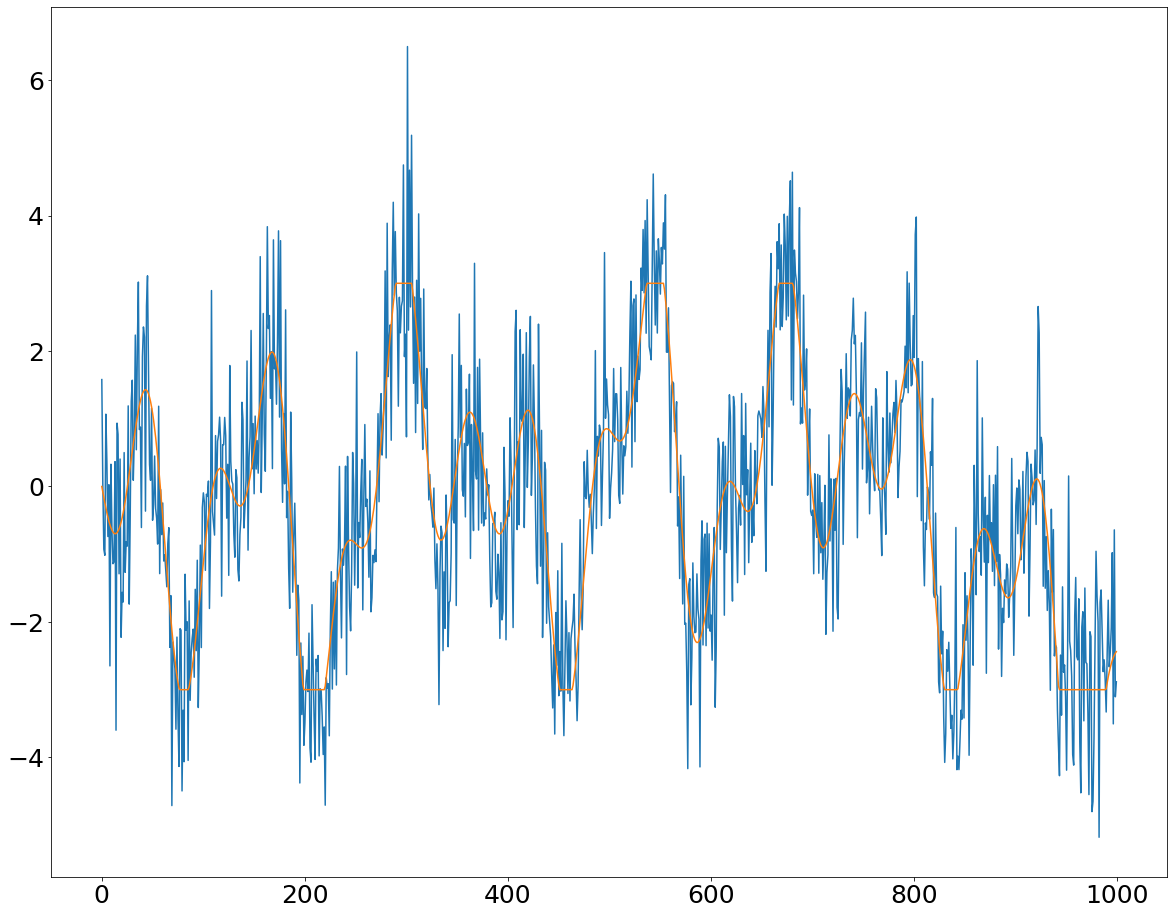

In [2]:
x_init = np.load("x_init.npy")
y = np.load("corrupted.npy")
y.shape, x_init.shape
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 25})
plt.plot(y)
plt.plot(x_init)

In [3]:
def func(x, y, lambda_=5):
    eps = 0.001
    psi = np.dot(x-y, x-y)
    dx = x[1:] - x[:-1]
    phi = np.sum(np.sqrt(eps ** 2 + dx ** 2) - eps)
    return psi + lambda_ * phi

In [4]:
def grad(x, y, lambda_=5):
    eps=0.001
    psi_grad = 2 * (x-y)
    dx = x[1:] - x[:-1]
    cnt2 = np.zeros(len(x) + 1)
    cnt2[1:-1] = dx / np.sqrt(eps ** 2 + dx ** 2)
    phi_grad = cnt2[:-1] - cnt2[1:]
    return psi_grad + lambda_ * phi_grad

### Метод Флетчера-Ривса

In [5]:
class CG_FR:           
    def __init__(self, StepSizeChoice, restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-4, max_iter=5000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next) / grad.dot(grad)
            p = -grad_next + beta * p
            grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
        return x

### Метод Полака-Рибьера

In [6]:
class CG_PR: 
    def __init__(self, StepSizeChoice, restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-4, max_iter=5000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next-grad) / grad.dot(grad)
            p = -grad_next + beta * p
            grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
        return x

### Метод Хестена-Штифеля

In [7]:
class CG_HS: 
    def __init__(self, StepSizeChoice, restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-4, max_iter=5000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            if np.dot(grad_next-grad,p)==0:
                beta=0
            else:
                beta = np.dot(grad_next,grad_next-grad) / np.dot(grad_next-grad,p)
            p = -grad_next + beta * p
            grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
        return x


In [8]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass
    
class Wolfe(StepSize):
    def __init__(self, beta1=0.3, beta2=0.9, rho1=0.1, rho2=2, alpha0=1):
        self.beta1, self.beta2 = beta1, beta2
        self.rho1, self.rho2 = rho1, rho2
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta1, rho1, alpha = self.beta1, self.rho1, self.alpha0
        beta2, rho2 = self.beta2, self.rho2
        lb, ub = 0, np.inf
        fx = f(x)
        g = gradf(x)
        hg = h.dot(g)
        while True:
            x_new = x + alpha * h
            if f(x_new) > fx + beta1 * alpha * hg:
                ub = alpha
                alpha = 1/2 * (lb + ub)
            elif gradf(x_new).dot(h) < beta2 * hg:
                lb = alpha
                if np.isinf(ub):
                    alpha = 2 * lb
                else:
                    alpha = 0.5 * (lb + ub)
            else:
                return alpha
            if ub - lb <= 1e-12:
                return alpha


In [9]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values


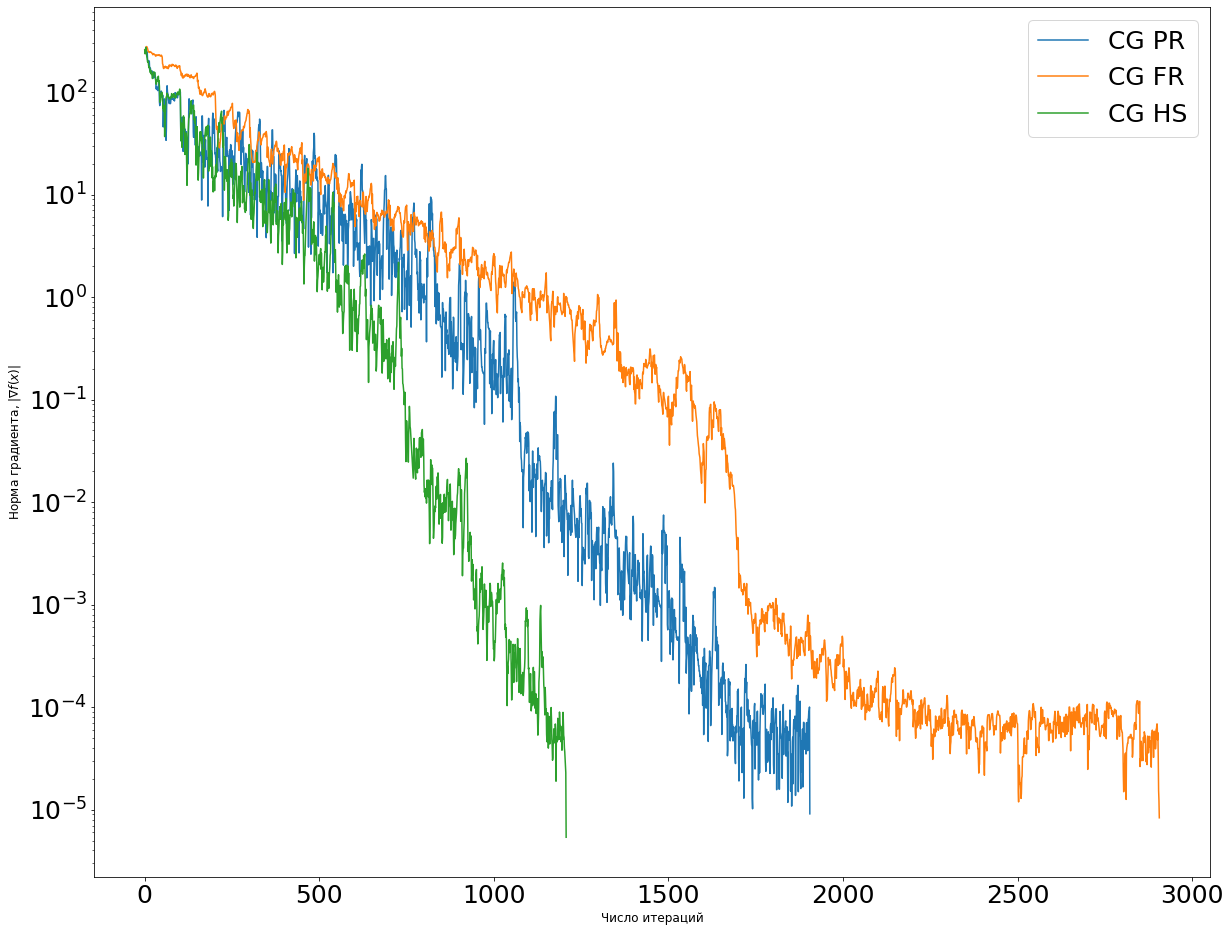

In [21]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 25}) 

methods = [
            CG_PR(Wolfe(beta1=0.1, beta2=0.5), restart=50, name="CG PR"),
            CG_FR(Wolfe(beta1=0.1, beta2=0.5), restart=50, name="CG FR"),
            CG_HS(Wolfe(beta1=0.1, beta2=0.5), restart=50, name="CG HS")
          ]

for method in methods:
    np.random.seed(0)
    method.solve(x0 = y, f = lambda x: func(x, y), 
                 gradf = lambda x: grad(x, y),
                 tol = 1e-5, max_iter = 5000)

funcx = lambda x: np.linalg.norm(grad(x, y))

for method in methods:
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)

plt.xlabel("Число итераций", fontsize=12)
plt.ylabel(r"Норма градиента, $\|\nabla f(x)\|$", fontsize=12)
plt.legend()
plt.show()


### Вывод: по итерациям быстрее Метод Хестена-Штифеля  

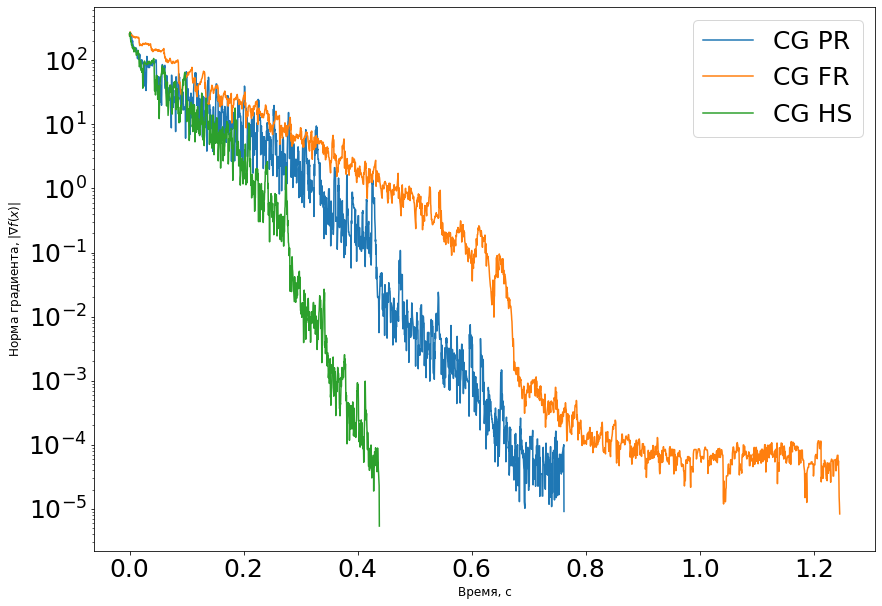

In [22]:
plt.figure(figsize=(14, 10))

for method in methods:
    times, values = parse_logs(method.history, ret_time=True, funcx=funcx)
    plt.semilogy(times, values, label=method.name)

plt.xlabel("Время, с", fontsize=12)
plt.ylabel(r"Норма градиента, $\|\nabla f(x)\|$", fontsize=12)
plt.legend()
plt.show()

### Вывод: по времени быстрее Метод Хестена-Штифеля

### Армихо

In [12]:
class Armijo(StepSize):
    def __init__(self, beta=0.3, rho=0.5, alpha0=1):
        self.beta = beta
        self.rho = rho
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta, rho, alpha = self.beta, self.rho, self.alpha0
        fx = f(x)
        gx = gradf(x)
        gxh = gx.dot(h)
        while f(x + alpha * h) > fx + beta * alpha * gxh:
            alpha *= rho
        return alpha


### Усокренный метод Нестерова

In [13]:
class Nesterov:
    def __init__(self, alpha=None, return_history=True, name=None):
        self.name = name
        self.alpha = alpha
        self.return_history = return_history
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        alpha = self.alpha
        x = x0.copy()
        k = 0
        x = x0.copy()
        x_prev = x0.copy()
        y = x0.copy()
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            x_prev, x = x, y - alpha * gradf(y)
            y = x + k/(k+3) * (x - x_prev)
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

### Градиентный спуск

In [14]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        x = x0.copy()
        for k in range(N):
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x = x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(gradf(x)) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

### Метод тяжелого шарика

In [15]:

class HeavyBall:
    def __init__(self, alpha=None, beta=None, L=None, mu=None, return_history=True, name=None):
        self.name = name
        if alpha is not None and beta is not None:
            self.alpha = alpha
            self.beta = beta
        else:
            self.alpha, self.beta = self.get_alpha_beta(L, mu)
        self.return_history = return_history
        self.history = []
    
    @staticmethod
    def get_alpha_beta(L, mu):
        alpha = 4 / (np.sqrt(L) + np.sqrt(mu))**2
        beta1 = (1 - np.sqrt(alpha * L))**2
        beta2 = (1 - np.sqrt(alpha * mu))**2
        beta = max(beta1, beta2)
        return alpha, beta
        
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        alpha, beta = self.alpha, self.beta
        x = x0.copy()
        x_prev = x0.copy()
        for k in range(N):
            g = gradf(x)
            x_prev, x = x, x - alpha * g + beta * (x - x_prev)
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        alpha, beta = self.alpha, self.beta
        x = x0.copy()
        k = 0
        x_prev = x0.copy()
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            g = gradf(x)
            x_prev, x = x, x - alpha * g + beta * (x - x_prev)
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

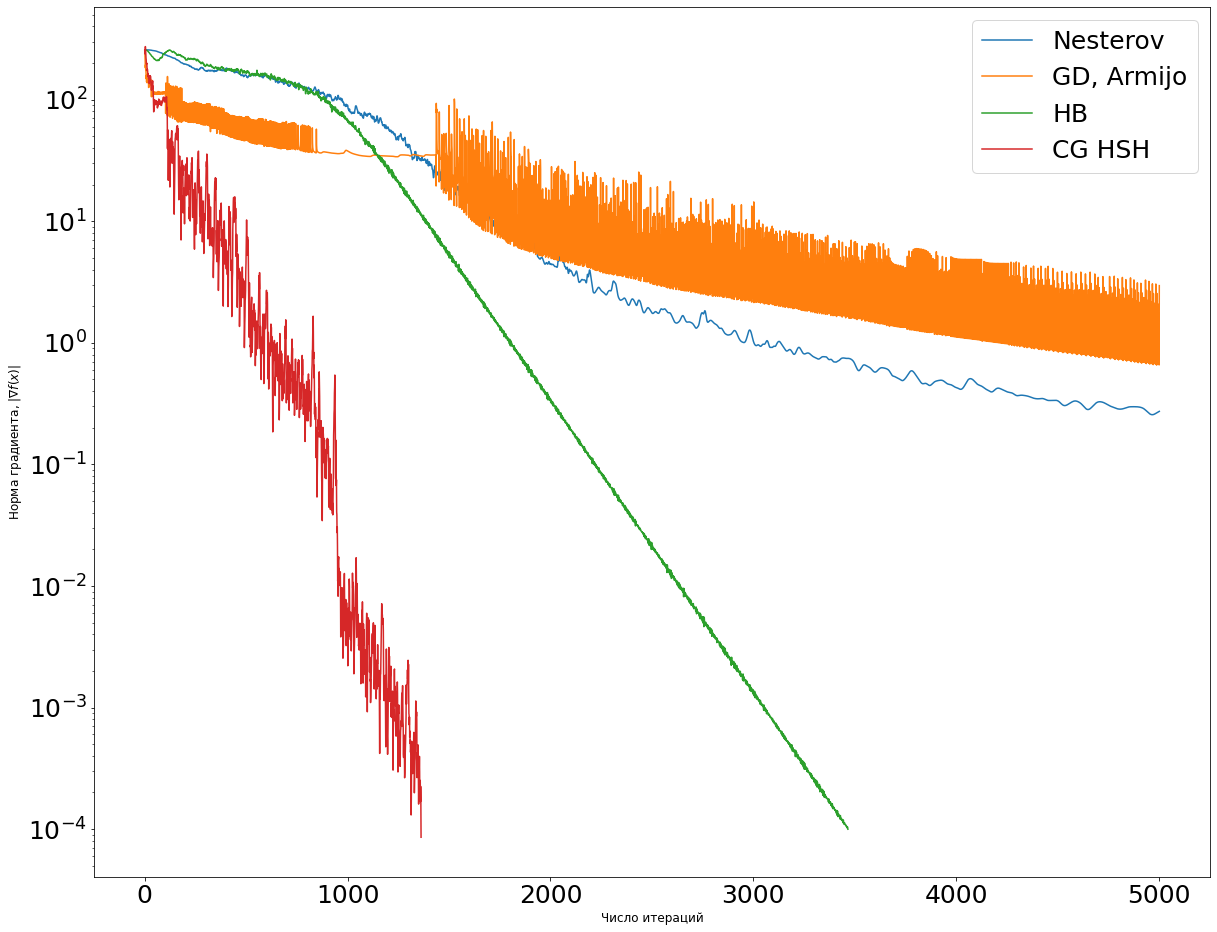

In [16]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 25})

methods = [
    Nesterov(alpha=1e-5, name="Nesterov"),
    GradientDescent(Armijo(rho=0.5), name="GD, Armijo"),
    HeavyBall(alpha=0.00004, beta=0.989,name="HB"),
    CG_HS(Wolfe(beta1=0.1, beta2=0.5), restart=0, name="CG HSH")
]

for method in methods:
    method.solve(x0 = y, 
                f = lambda x: func(x, y), 
                gradf = lambda x: grad(x, y),
                tol = 1e-4,
                max_iter = 5000)
    

funcx = lambda x: np.linalg.norm(grad(x, y))
for method in methods:
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)

plt.xlabel("Число итераций", fontsize=12)
plt.ylabel(r"Норма градиента, $\|\nabla f(x)\|$", fontsize=12)
plt.legend()
plt.show()


### Вывод: по итерациям быстрее Метод Хестена-Штифеля

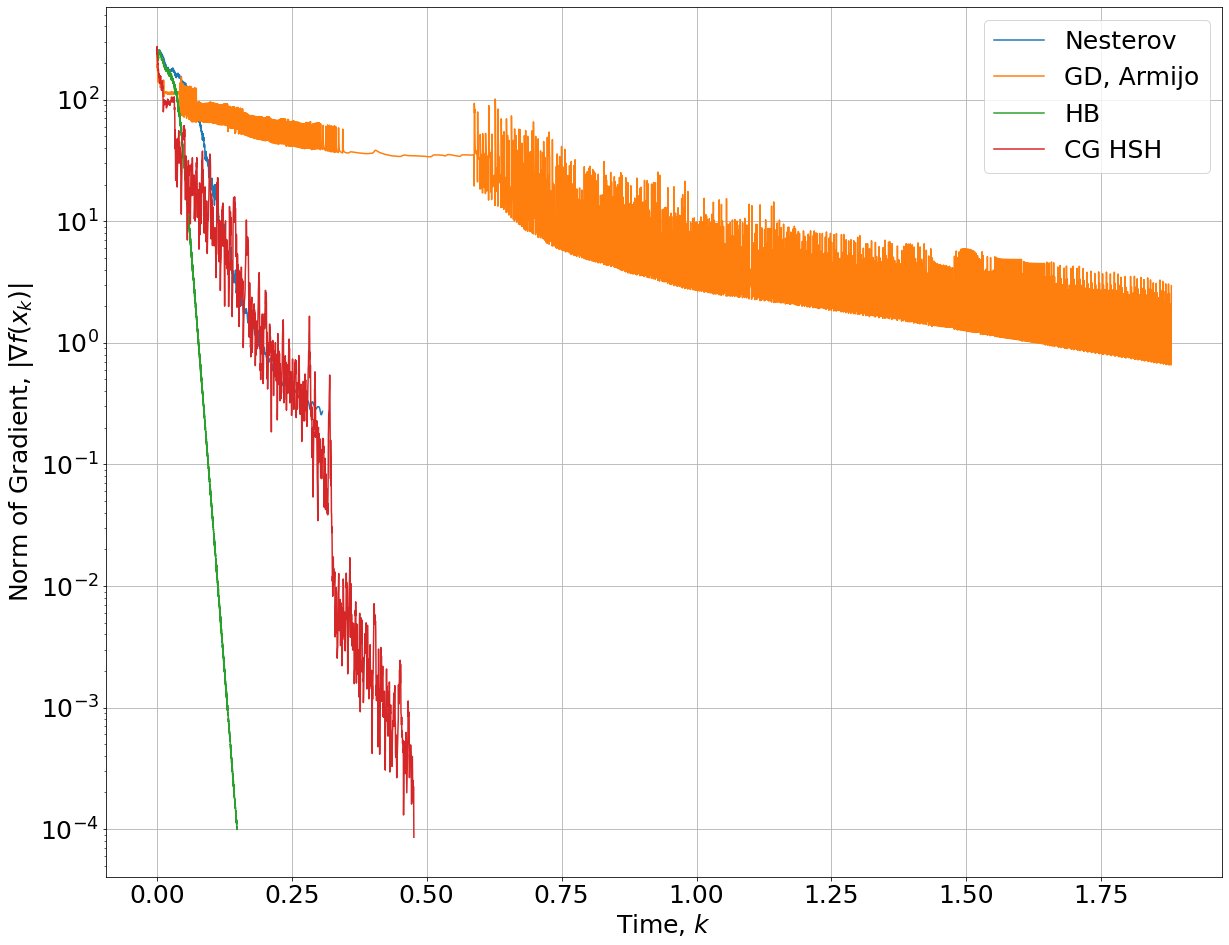

In [17]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 25})
for method in methods:
    xhistory = method.history
    timee_h, values = parse_logs(method.history, ret_time=True, funcx=funcx)
    plt.semilogy(timee_h, values, label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Time, $k$")
plt.legend()

### Вывод: по времени быстрее метод тяжелого шарика

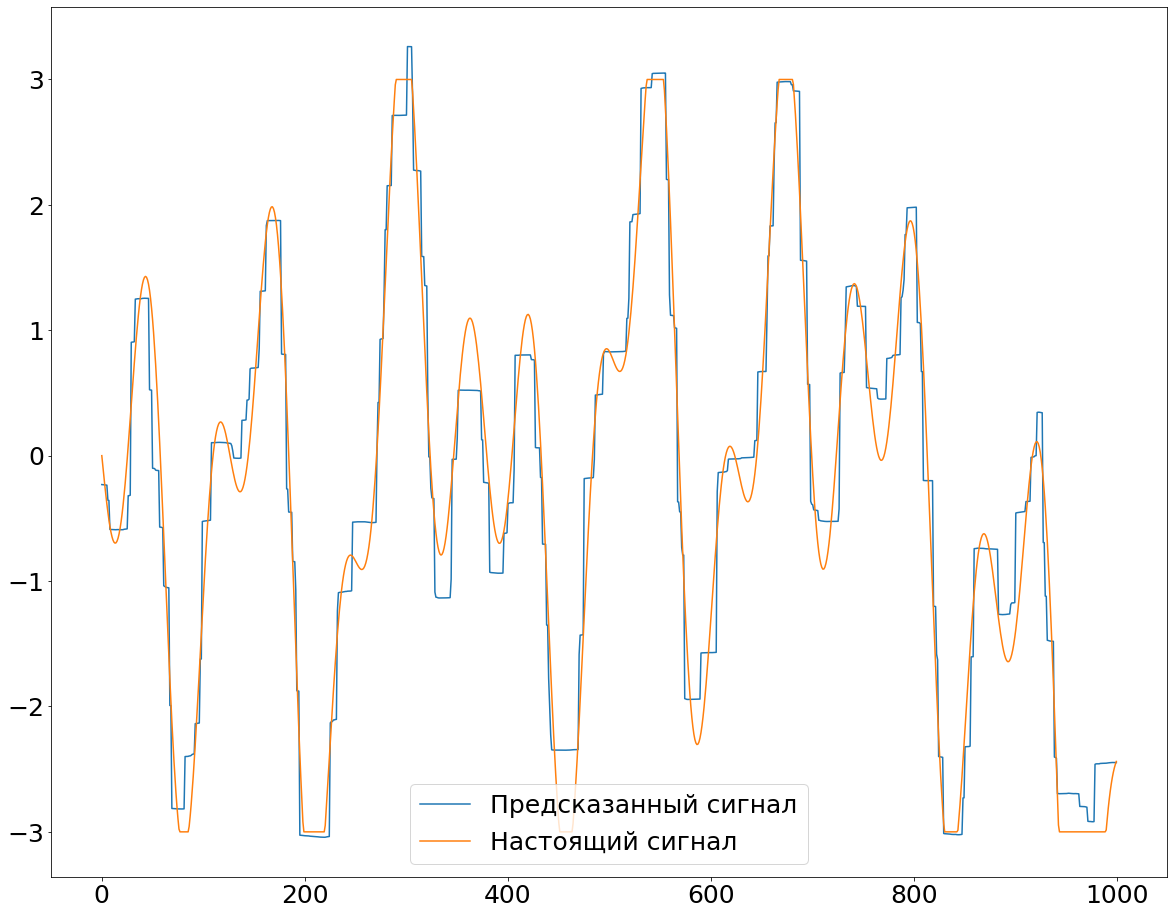

In [18]:
y.shape, x_init.shape
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 25})
res_method=CG_HS(Wolfe(beta1=0.1, beta2=0.4), restart=0, name=r"CG HSH, restart={}".format(0)) 
x_pred = method.solve(
    x0 = y, 
    f = lambda x: func(x, y), 
    gradf = lambda x: grad(x, y),
    tol = 1e-5,
    max_iter = 100000)

plt.plot(x_pred, c='tab:blue', label='Предсказанный сигнал')
plt.plot(x_init, c='tab:orange', label='Настоящий сигнал')
plt.legend()
plt.show()